In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.4.1


In [ ]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re


In [3]:
!ls 'gdrive/My Drive/Twitter_sentiment/input'

clean_covid_input.csv  training.1600000.processed.noemoticon.csv
clean_covid_pred.csv   vaccination_tweets.csv
clean_input.csv


In [71]:
col_names=['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'tweet', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet']

In [72]:
df = pd.read_csv('gdrive/My Drive/Twitter_sentiment/input/vaccination_tweets.csv', names=col_names)

In [73]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,tweet,hashtags,source,retweets,favorites,is_retweet
0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
1,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
3,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
4,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False


In [35]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'tweet', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [43]:
df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified','date', 'hashtags', 'source', 'retweets', 'favorites','is_retweet'],axis=1,inplace=True)

## Data Cleaning

In [44]:

# Lower Case
df["tweet"] = df["tweet"].map(lambda x: x.lower())

# Removing Emails
df["tweet"] = df["tweet"].str.replace(r'(\w+\.)*\w+@(\w+\.)+[a-z]+', '')

# Removing URL's
df["tweet"] = df["tweet"].str.replace(r'(http|ftp|https)://[-\w.]+(:\d+)?(/([\w/_.]*)?)?|www[\.]\S+', '')

# Removing hashtag
df["tweet"] = df["tweet"].str.replace(r'[\@\#]\S+', '')

In [45]:

# Converting Emoticons
emo_info = {
    # positive emoticons
    ":‑)": " good ",
    ":)": " good ",
    ";)": " good ",
    ":-}": " good ",
    "=]": " good ",
    "=)": " good ",
    ";d": " good ",
    ":d": " good ",
    ":dd": " good ",
    "xd": " good ",
    ":p": " good ",
    "xp": " good ",
    "<3": " love ",

    # negative emoticons
    ":‑(": " sad ",
    ":‑[": " sad ",
    ":(": " sad ",
    "=(": " sad ",
    "=/": " sad ",
    ":{": " sad ",
    ":/": " sad ",
    ":|": " sad ",
    ":-/": " sad ",
    ":o": " shock "
}

emo_info_order = [k for (k_len, k) in reversed(sorted([(len(k), k) for k in emo_info.keys()]))]

def emo_repl(phrase):
    for k in emo_info_order:
        phrase = phrase.replace(k, emo_info[k])
    return phrase

df['tweet'] = df['tweet'].apply(emo_repl)


In [46]:
# Expanding Contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"\bdon't\b", "do not", phrase)
    phrase = re.sub(r"\bdoesn't\b", "does not", phrase)
    phrase = re.sub(r"\bdidn't\b", "did not", phrase)
    phrase = re.sub(r"\bdidnt\b", "did not", phrase)
    phrase = re.sub(r"\bhasn't\b", "has not", phrase)
    phrase = re.sub(r"\bhaven't\b", "have not", phrase)
    phrase = re.sub(r"\bhavent\b", "have not", phrase)
    phrase = re.sub(r"\bhadn't\b", "had not", phrase)
    phrase = re.sub(r"\bwon't\b", "will not", phrase)
    phrase = re.sub(r"\bwouldn't\b", "would not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)

    # using regular expressions to expand the contractions
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

df['tweet'] = df['tweet'].apply(decontracted)

In [47]:

# Removing Stop Words

stop = stopwords.words('english')
manual_sw_list = ['retweet', 'retwet', 'rt', 'oh', 'dm', 'mt', 'ht', 'ff', 'shoulda', 'woulda', 'coulda', 'might', 'im', 'tb', 'mysql', 'hah', "a", "an", "the", "and", "but", "if",
                  "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
                  "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "nor", "only", "own", "same", "so", "than", "too", "very", "s",
                  "t", "just", "don", "now", 'tweet', 'x', 'f']

stop.extend(manual_sw_list)

df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [48]:
# Applying Lemmatization

lem = WordNetLemmatizer()
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([lem.lemmatize(word, 'v') for word in x.split()]))

# Removing extra punctuations

df["tweet"] = df["tweet"].str.replace(r'[^\w\s]', '')

# Removing Digits

df["tweet"] = df["tweet"].str.replace(r'[0-9]+', '')

# Removing Non-Alphabet

non_alphabet = re.compile(r'[^a-z]+')
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if non_alphabet.search(word) is None]))

# Removing Duplicate Letters

df['tweet'] = df['tweet'].str.replace(r'([a-z])\1{1,}', r'\1\1')
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word if len(wordnet.synsets(word)) > 0 else re.sub(r'([a-z])\1{1,}', r'\1', word) for word in x.split()]))

# Cutting Duplicate Laughing Sound

df['tweet'] = df['tweet'].str.replace(r'(ha)\1{1,}', r'\1')

# Remove Empty Rows

df.drop(df[df["tweet"] == ''].index, inplace=True)
df = df.reset_index(drop=True)



In [49]:
df.head()

,tweet
0,text
1,folks say daikon paste could treat cytokine storm
2,world wrong side history year hopefully bigges...
3,russian vaccine create last years
4,facts immutable senator even ethically sturdy ...


In [50]:
df.to_csv('gdrive/My Drive/Twitter_sentiment/input/clean_covid_input.csv')

## Using the pre-trained model to predict covid vaccine tweets

In [5]:
df = pd.read_csv('gdrive/My Drive/Twitter_sentiment/input/clean_covid_input.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.columns

Index(['tweet'], dtype='object')

In [7]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 3.3MB 49.6MB/s 
     |████████████████████████████████| 901kB 37.1MB/s 


In [8]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [9]:
# use this line to import the exported model
model = TFBertForSequenceClassification.from_pretrained("gdrive/My Drive/Twitter_sentiment/output/bert75k")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at gdrive/My Drive/Twitter_sentiment/output/bert75k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [10]:
df.head()

,tweet
0,text
1,folks say daikon paste could treat cytokine storm
2,world wrong side history year hopefully bigges...
3,russian vaccine create last years
4,facts immutable senator even ethically sturdy ...


In [32]:
labelArray = []

In [34]:
for i in range(len(df)): 
  sample_input = tokenizer(df['tweet'].iloc[i], max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(sample_input)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  labels = ['Negative','Positive']
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()
  # labelArray+=label
  labelArray.append(label[0])
print('done')
  # for i in range(len(pred_sentences)):
  #   print(pred_sentences[i], ": \n", labels[label[i]])

done


In [35]:
len(labelArray)

8014

In [37]:
labelArray[1:10]

[0, 0, 0, 1, 0, 0, 0, 1, 0]

In [38]:
df['predicted_label'] = labelArray

In [42]:
df.drop(index=0, inplace=True)

In [43]:
df.head()

,tweet,predicted_label
1,folks say daikon paste could treat cytokine storm,0
2,world wrong side history year hopefully bigges...,0
3,russian vaccine create last years,0
4,facts immutable senator even ethically sturdy ...,1
5,e good lie need vaccine,0


In [44]:
df.to_csv('gdrive/My Drive/Twitter_sentiment/input/clean_covid_pred.csv')

## Visualizations

In [74]:
pred_df = pd.read_csv('gdrive/My Drive/Twitter_sentiment/input/clean_covid_pred.csv')
pred_df.drop('Unnamed: 0', axis=1, inplace=True)

In [75]:
df.drop(index=0, inplace=True)
df['label'] = pred_df['predicted_label']


In [76]:
df_save = df

In [68]:
df = df_save

In [77]:
df_save.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,tweet,hashtags,source,retweets,favorites,is_retweet,label
1,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.0
2,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,0.0
3,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,1.0
4,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,0.0
5,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,0.0


In [80]:
df.dtypes

id                   object
user_name            object
user_location        object
user_description     object
user_created         object
user_followers       object
user_friends         object
user_favourites      object
user_verified        object
date                 object
tweet                object
hashtags             object
source               object
retweets            float64
favorites           float64
is_retweet           object
label               float64
dtype: object

In [79]:
df['retweets']=df.retweets.astype(float)
df['favorites']=df.favorites.astype(float)

In [81]:
df['user_verified']=df['user_verified'].apply(lambda x:'verified' if x==True else 'not_verified')
from datetime import date
df['today']=date.today()
df['user_created']=pd.to_datetime(df['user_created']).dt.year
df['today']=pd.to_datetime(df['today'])
df['today']=df['today'].dt.year
df['acc_age']= df['today']-df['user_created']
df['total_engagement']=df['retweets']+df['favorites']
df['tweet_lenght']=df['tweet'].apply(lambda x:len(x))
df['tweet_lenght'].describe()
df['tweet_length']=df['tweet'].apply(lambda x:'short' if len(x)<=130 else 'long')

In [82]:
df['date']=pd.to_datetime(df['date'])
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [83]:
loc_df = df['user_location'].str.split(',',expand=True)
loc_df=loc_df.rename(columns={0:'first_loc',1:'second_loc'})

# Remove Spaces 
loc_df['second_loc'] = loc_df['second_loc'].str.strip()
# Rename States 
state_fix = {'Ontario': 'Canada','United Arab Emirates': 'UAE','TX': 'USA','NY': 'USA'
                  ,'FL': 'USA','England': 'UK','Watford': 'UK','GA': 'USA','IL': 'USA'
                  ,'Alberta': 'Canada','WA': 'USA','NC': 'USA','British Columbia': 'Canada','MA': 'USA','ON':'Canada'
            ,'OH':'USA','MO':'USA','AZ':'USA','NJ':'USA','CA':'USA','DC':'USA','AB':'USA','PA':'USA','SC':'USA'
            ,'VA':'USA','TN':'USA','New York':'USA','Dubai':'UAE','CO':'USA'}
loc_df = loc_df.replace({"second_loc": state_fix}) 
loc_df['second_loc'].value_counts()[:20]

USA                863
UK                 540
Canada             186
India              178
Ireland             91
UAE                 77
United Kingdom      75
Germany             61
Belgium             26
France              24
South Africa        23
Scotland            22
Pakistan            19
London              17
Qatar               17
New South Wales     16
Malaysia            16
Deutschland         16
MI                  16
Australia           15
Name: second_loc, dtype: int64

In [84]:
df['Hash'] = df['tweet'].apply(lambda word:word.count('#'))

In [85]:
df['Men'] = df['tweet'].apply(lambda word:word.count('@'))

In [86]:
#('https://t.co/) this part in tweets refers to photos,videos
df['med'] = df['tweet'].apply(lambda word:word.count('https://t.co/'))
df['med'] = df['med'].apply(lambda x:'No Media' if x==0 else 'Media')

In [87]:
df['user_followers'].value_counts()

2        52
1        44
106      41
0        38
6        36
         ..
626       1
2027      1
7460      1
17928     1
1413      1
Name: user_followers, Length: 2991, dtype: int64

In [88]:
df['acc_class'] = df['user_followers'].apply(lambda x:'weak'if int(x)<=100 else ('norm' if 1000>=int(x)>100 else ('strong' if 10000>=int(x)>1000 else 'influencer')))
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,tweet,hashtags,source,retweets,favorites,is_retweet,label,today,acc_age,total_engagement,tweet_lenght,tweet_length,year,month,day,dayofweek,dayofyear,weekofyear,quarter,Hash,Men,med,acc_class
1,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,not_verified,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,0.0,2021,12,0.0,97,short,2020,12,20,6,355,51,4,1,0,Media,norm
2,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,not_verified,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,0.0,2021,12,2.0,140,long,2020,12,13,6,348,50,4,0,0,Media,norm
3,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,not_verified,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,1.0,2021,1,0.0,140,long,2020,12,12,5,347,50,4,6,0,Media,weak
4,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,not_verified,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,0.0,2021,13,2575.0,140,long,2020,12,12,5,347,50,4,0,0,Media,influencer
5,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,not_verified,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,0.0,2021,1,0.0,135,long,2020,12,12,5,347,50,4,2,2,Media,norm


In [89]:
df=df[['user_name','tweet','date', 'acc_age','user_verified','retweets','favorites','total_engagement', 'day', 'tweet_length',
       'Hash', 'Men', 'med', 'acc_class','month','label']]
df_copy=df.copy()

In [90]:
df.head()

,user_name,tweet,date,acc_age,user_verified,retweets,favorites,total_engagement,day,tweet_length,Hash,Men,med,acc_class,month,label
1,Rachel Roh,Same folks said daikon paste could treat a cyt...,2020-12-20 06:06:44,12,not_verified,0.0,0.0,0.0,20,short,1,0,Media,norm,12,0.0
2,Albert Fong,While the world has been on the wrong side of ...,2020-12-13 16:27:13,12,not_verified,1.0,1.0,2.0,13,long,0,0,Media,norm,12,0.0
3,eli🇱🇹🇪🇺👌,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,2020-12-12 20:33:45,1,not_verified,0.0,0.0,0.0,12,long,6,0,Media,weak,12,1.0
4,Charles Adler,"Facts are immutable, Senator, even when you're...",2020-12-12 20:23:59,13,not_verified,446.0,2129.0,2575.0,12,long,0,0,Media,influencer,12,0.0
5,Citizen News Channel,Explain to me again why we need a vaccine @Bor...,2020-12-12 20:17:19,1,not_verified,0.0,0.0,0.0,12,long,2,2,Media,norm,12,0.0


In [91]:
df.dtypes

user_name                   object
tweet                       object
date                datetime64[ns]
acc_age                      int64
user_verified               object
retweets                   float64
favorites                  float64
total_engagement           float64
day                          int64
tweet_length                object
Hash                         int64
Men                          int64
med                         object
acc_class                   object
month                        int64
label                      float64
dtype: object

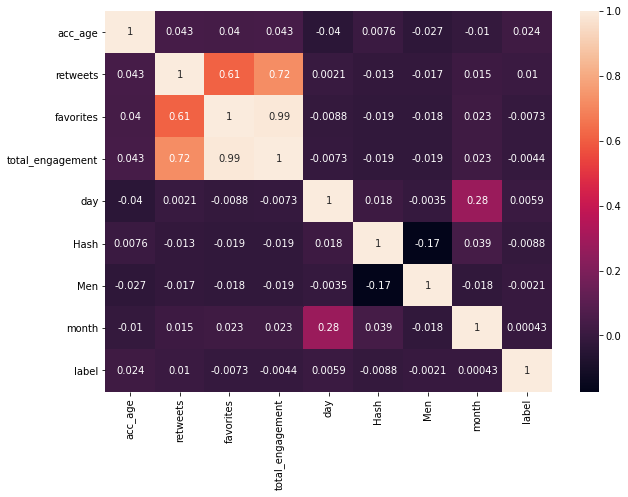

In [92]:
corr=df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True)

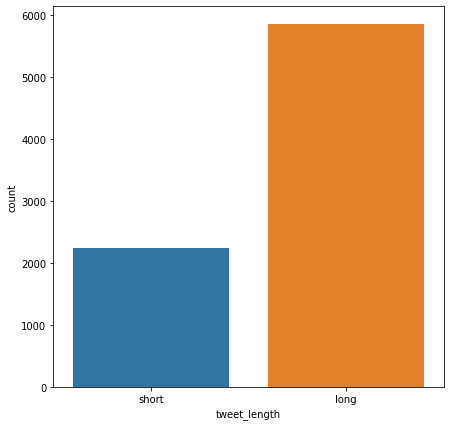

In [93]:
plt.figure(figsize=(7,7))
sns.countplot(x='tweet_length',data=df);

(-1.1505029161234455,
 1.0574951215706034,
 -1.2009314800414903,
 1.1048062907740432)

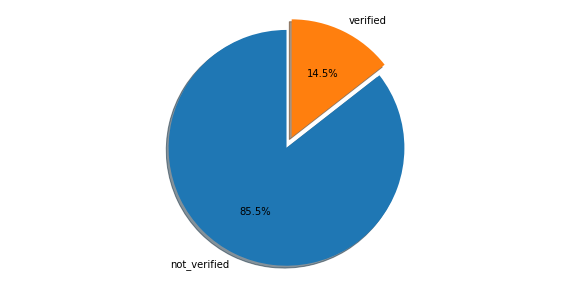

In [94]:
labels = 'not_verified', 'verified'
sizes = [1888, 319]
explode = (0.1, 0)  
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
plt.axis('equal')

In [95]:
class_eng = df.groupby('acc_class',as_index=False).agg({'total_engagement':'sum',})

In [96]:
fig = px.bar(class_eng,
             x='acc_class',
             y='total_engagement',
             color='total_engagement',
             color_continuous_scale='Rainbow',
             title='Engagement By Account_Class')
fig.show()

In [97]:
Media = len(df[df['med']=='Media'])
No_Media = len(df[df['med']=='No Media'])
Platform = ['Media','No Media']
Count = [Media,No_Media]
#====
fig = px.pie(names = Platform,
             values = Count,
             title='Media/No Media',
            color_discrete_sequence = px.colors.sequential.Rainbow)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [100]:
line = df.groupby('date',as_index=False).agg({'total_engagement':'sum'})
fig = go.Figure()
fig.add_trace(go.Scatter(x=line.date, y=line.total_engagement,
                    mode='lines+markers'))

In [101]:
december=df.loc[df['month']==12]
day_december = december.groupby('day',as_index=False).agg({'total_engagement':'sum'})

fig = px.scatter(day_december,
                 x='day',
                 y='total_engagement',
                 color_continuous_scale='Rainbow',
                 color='total_engagement',
                 size='total_engagement',
                 title='Most engaged days in December')
fig.show()

In [102]:
january=df.loc[df['month']==1]
day_january = january.groupby('day',as_index=False).agg({'total_engagement':'sum'})

fig = px.scatter(day_january,
                 x='day',
                 y='total_engagement',
                 color_continuous_scale='Rainbow',
                 color='total_engagement',
                 size='total_engagement',
                 title='Most engaged days in january')
fig.show()

In [103]:
df3=pd.DataFrame(loc_df['second_loc'].value_counts()[:20]).reset_index()
df3

,index,second_loc
0,USA,863
1,UK,540
2,Canada,186
3,India,178
4,Ireland,91
5,UAE,77
6,United Kingdom,75
7,Germany,61
8,Belgium,26
9,France,24


In [105]:
fig = px.choropleth(df3, locations = df3['index'],
                    color = df3['second_loc'],locationmode='country names',hover_name = df3['second_loc'], 
                    color_continuous_scale = px.colors.sequential.Inferno)
fig.update_layout(title='Tweets By Region')
fig.show()

### Positive to negative tweet ratio


In [112]:

Negative = len(df[df['label']==0])
Positive = len(df[df['label']==1])
labels = ['Negative','Positive']
values = [Negative,Positive]

import plotly.graph_objects as go
colors = ['red','green' ]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,textposition='inside',
                  marker=dict(colors=colors, line=dict(color='grey', width=1)))
fig.show()

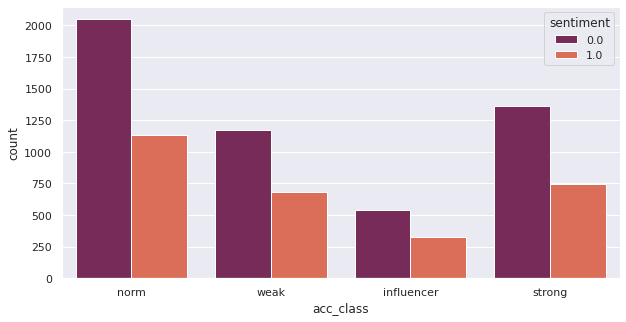

In [113]:
df_copy['sentiment'] = df['label']
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(x=df_copy['acc_class'],data=df_copy,hue=df_copy['sentiment'],palette="rocket")